# Texas Death Row Data

Some related links


1. [Texas JOD Death Row Site](https://www.tdcj.texas.gov/death_row/)
2. [Brian Klaas on Last Words of Death Row Inmates](https://www.forkingpaths.co/p/the-last-statements-of-death-row)
 
From Klaas's essay:

> Since 1976—when the Supreme Court issued a ruling that allowed the revival of capital punishment in the United States—there have been 581 executions carried out in the Huntsville Unit. That’s about 4 in 10 of all executions in the United States, in a single cramped chamber, in a small town in Texas.

Between the time this blog was posted and the time of the
creation of this notebook, the number of executions has risen to 583. 


This notebook is a case study in data cleanup.  A number of inconsistencies in the data are handled.

In [156]:
#https://www.tdcj.texas.gov/death_row/dr_executed_offenders.html
site = "https://www.tdcj.texas.gov/death_row/"
base_url = site + "dr_executed_offenders.html"

In [157]:
import os
import sys
from bs4 import BeautifulSoup
import urllib.request


def parseHtml(html):
    return BeautifulSoup(html, "lxml").contents

class DummyAnchor ():

    def __init__ (self,href,title,text):
    
       self.__dict__ =  dict(href=href,
                             title=title)
       self.text = text
       
    def __getitem__ (self,key):
        return self.__dict__[key]
    
    def __repr__ (self):
        return f'<a href={self["href"]} title={self["title"]}>{self.text}</a>'
    
def make_dummy_last_statement_anchor (name):
    L = name.split()
    lastfirst = ("".join(L[1:] + [L[0]])).lower()
    href=f"dr_info/{lastfirst}last.html"
    title=f"Last Statement of {name}"
    text = "Last Statement"
    return DummyAnchor(href,title,text)

def make_dummy_info_anchor (name):
    L = name.split()
    lastfirst = ("".join(L[1:] + [L[0]])).lower()
    href=f"dr_info/{lastfirst}.html"
    title=f"Inmate Information for {name}"
    text = "Inmate Information"
    return DummyAnchor(href,title,text)




### Extract the data table from the executed offenders page

Note this just grabs the table displayed on the TX executions page.  It doesn't follow
any of the links to the statements and inmate data.

In [158]:
#print(urllib.request.urlopen.__doc__)
import ssl
import urllib.request

ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

with urllib.request.urlopen(base_url, context=ctx) as f:
    inmate_list_page = f.read()


In [159]:
soup_bowl = parseHtml(inmate_list_page)

584 rows, including the headed row (= 583 executions).

In [160]:
table = soup_bowl[1]('table')[0]
rows = table('tr')
len(rows)

584

10 columns, which include the 2 link columns we are handling later in this NB.

In [350]:
len(rows[0]('th'))

10

### Convert the HTML data table into a `pandas` `DataFrame`.

Note:  It might seem that this step could be simpler, because `pd.read_html` accepts a URL as an argument; so
we could just just call
`pd.read_html` on the URL string, and avoid  using `inmate_list_page`, which is the `bytes` object downloaded
from the URL.

However, having the `bytes` object allows us to use `BeautifulSoup` (called in `parseHTML` above).
We can then get our hands on the links to the statements and inmate data, which are not being
handled correctly in `pd.read_html`.  

These links are used later in this notebook to

1.  Represent them as strings in the table that has the statements and info columns restored (created below).
2.  Download the data from the web pages they point to.

In [161]:
import pandas as pd

table_TX = pd.read_html(inmate_list_page)[0]
# Temporarily Omitting Statements and Info columns, which are handled below.
table_TX = table_TX.iloc[:,[0,3,4,5,6,7,8,9]]
table_TX.set_index("Execution",inplace=True)
table_TX["Date"] = [pd.to_datetime(val) for val in table_TX["Date"].values]

# The parser used for astype casting doesnt work.  The mystery is why the version above does.
#converted_dates = table_TX['Date'].values.astype('datetime64[D]')

Some facts about the data:

In [162]:
table_TX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 583 to 1
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Last Name    583 non-null    object        
 1   First Name   583 non-null    object        
 2   TDCJ Number  583 non-null    int64         
 3   Age          583 non-null    int64         
 4   Date         583 non-null    datetime64[ns]
 5   Race         583 non-null    object        
 6   County       583 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 36.4+ KB


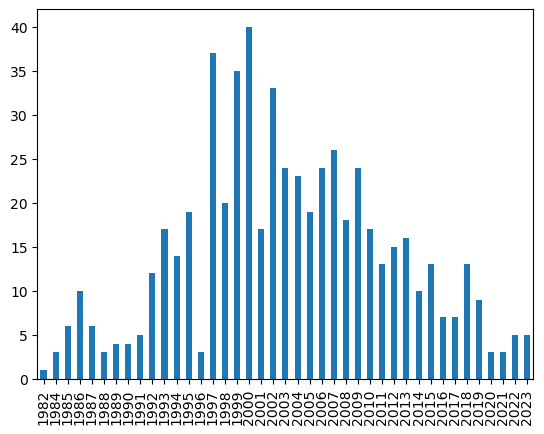

In [163]:
#  Example vectorized of pd.Datetime column
executions_by_year = table_TX["Date"].dt.year.value_counts(sort=False).sort_index()
bar_plot = executions_by_year.plot(kind="bar")

In [164]:
print(f"{table_TX['Age'].mean():.3f}")

40.082


In [165]:
with pd.option_context('display.precision', 3):
    print(table_TX["Race"].value_counts(normalize=True))

White       0.446
Black       0.358
Hispanic    0.190
Other       0.005
Name: Race, dtype: float64


### Add Statement and Info Links to DataFrame (Optional)

Since we process the links and save the contents as files further on in this NB,
there is no real need to add the statement and Info links to this DataFrame.

Nevertheless we describe an option for restoring the link information
to the DataFrame, and we also provide a way for the links to be clickable.

In [166]:
# These functions are no longer in use
#def make_anchor (sp,site=''):
#    """
#    Turn a soup object anchor into an html string anchor,
#    converting the URL to be non-relative.
#    """
#    new_url = site + sp['href']
#   return f"<a href={new_url} title={sp['title']}>{sp.text}</a>"

#def make_anchors (col,site=''):
#    #col = get_col(row_cells,index)
#    return [make_anchor(cell('a')[0],site=site) for cell in col]

def get_col (row_cells,index):
        return [r[index] for r in row_cells]

def make_clickable(url, site, text):
    return f'<a rel="noopener noreferrer" href="{site + url}" target="_blank">{text}</a>'

# Need one-argument functions that apply to data items.  
# OK since the non-url args of `make_clickable` are fixed.
# NB:  The `site` variable must be defined at the time this cell is executed,
make_clickable_info = lambda url: make_clickable(url, site=site, text="Inmate Information")
make_clickable_statement = lambda url: make_clickable(url, site=site, text="Inmate's Statement")


Following [Pandas Tutorial Hint](https://github.com/softhints/Pandas-Tutorials/blob/master/styling/create-clickable-link-pandas-dataframe-jupyterlab.ipynb), leave the URLS as (relative-URL) strings and make them clickable
via a style formatting function.

One advantage of doing it this way is information-persistence.  This
makes the links to the website explicit in
the DataFrame as strings, so they can be saved with `df.to_csv()`.
They can still be **displayed** as clickable links, as we'll see.

In [244]:
# inmate_list_page is the bytes object downloaded with urllib.request.urlopen above
# These next lines are for context and are contained in earlier cells which should be
# executed before executing this cell.

#soup_bowl = parseHtml(inmate_list_page)
#table = soup_bowl[1]('table')[0]
#rows = table('tr')

# rows as extracted from the  Beautiful Soup parse of the 
# Texas JOD Death Row Site (defined above)  omitting header row.
row_cells = [row('td') for row in rows[1:]]

# Get data from 2nd cell in each row
info_col = get_col (row_cells,1)
# Get data from 3rd cell in each row
statement_col = get_col (row_cells,2)


# Get just the url strings to be used a data items
info_links0 = [f"{td_tag('a')[0]['href']}" for td_tag in info_col]
statement_links0 = [f"{td_tag('a')[0]['href']}" for td_tag in statement_col]

# Add the link sequences as cols
table_TX['Info']  = info_links0
table_TX['Statements']  = statement_links0

The DataFrame in this format:

In [245]:
table_TX[:10]

,Last Name,First Name,TDCJ Number,Age,Date,Race,County,Info,Statements
Execution,,,,,,,,,
583,"Brown, Jr.",Arthur,999110,52,2023-03-09,Black,Harris,dr_info/brownarthur.jpg,dr_info/brownarthurlast.html
582,Green,Gary,999561,51,2023-03-07,Black,Dallas,dr_info/greengary.html,dr_info/greengarylast.html
581,Balentine,John,999315,54,2023-02-09,Black,Potter,dr_info/balentinejohn.html,dr_info/balentinejohnlast.html
580,Ruiz,Wesley,999536,43,2023-02-01,Hispanic,Dallas,dr_info/ruizwesley.html,dr_info/ruizwesleylast.html
579,Fratta,Robert,999189,65,2023-01-10,White,Harris,dr_info/frattarobert.jpg,dr_info/frattarobertlast.html
578,Barbee,Stephen,999507,55,2022-11-16,White,Tarrant,dr_info/barbeestephen.html,dr_info/barbeestephenlast.html
577,Beatty,Tracy,999484,61,2022-11-09,White,Smith,dr_info/beattytracy.html,dr_info/beattytracylast.html
576,Ramirez,John,999544,38,2022-10-05,Hispanic,Nueces,dr_info/ramirezjohn.html,dr_info/ramirezjohnlast.html
575,Chanthakoummane,Kosol,999529,41,2022-08-17,Other,Collin,dr_info/chanthakoummanekosoul.html,dr_info/chanthakoummanekosollast.html


For clickable links, display using a formatting dict providing column-specific hooks for the 
formatting functions defined above:

In [347]:

#base_url = https://www.tdcj.texas.gov/death_row/dr_executed_offenders.html
#site = "https://www.tdcj.texas.gov/death_row/"

table_TX[:10].style.format({'Info': make_clickable_info,
                       'Statements': make_clickable_statement})

,Last Name,First Name,TDCJ Number,Age,Date,Race,County,Info,Statements
Execution,,,,,,,,,
583,"Brown, Jr.",Arthur,999110,52,2023-03-09 00:00:00,Black,Harris,Inmate Information,Inmate's Statement
582,Green,Gary,999561,51,2023-03-07 00:00:00,Black,Dallas,Inmate Information,Inmate's Statement
581,Balentine,John,999315,54,2023-02-09 00:00:00,Black,Potter,Inmate Information,Inmate's Statement
580,Ruiz,Wesley,999536,43,2023-02-01 00:00:00,Hispanic,Dallas,Inmate Information,Inmate's Statement
579,Fratta,Robert,999189,65,2023-01-10 00:00:00,White,Harris,Inmate Information,Inmate's Statement
578,Barbee,Stephen,999507,55,2022-11-16 00:00:00,White,Tarrant,Inmate Information,Inmate's Statement
577,Beatty,Tracy,999484,61,2022-11-09 00:00:00,White,Smith,Inmate Information,Inmate's Statement
576,Ramirez,John,999544,38,2022-10-05 00:00:00,Hispanic,Nueces,Inmate Information,Inmate's Statement
575,Chanthakoummane,Kosol,999529,41,2022-08-17 00:00:00,Other,Collin,Inmate Information,Inmate's Statement


Data cleanup note: The spelling of this inmate's name in the info file link was fixed by hand
after the file was downloaded.  Note the name "Frances/Francis" is spelled two different
ways in the anchor and the First Name col.  This inmate is in fact female and the male spelling was used
in the anchor link.

In [170]:
rows = table_TX[(table_TX["Last Name"].str.startswith("Newton"))]
rows.style.format({'Info': make_clickable_info,
                       'Statements': make_clickable_statement})

,Last Name,First Name,TDCJ Number,Age,Date,Race,County,Info,Statements
Execution,,,,,,,,,
349,Newton,Frances,922,40,2005-09-14 00:00:00,Black,Harris,"Inmate Information"" target=""_blank"">Inmate Information","Last Statement"" target=""_blank"">Inmate's Statement"


### Save DateFrame to CSV

Note this should be done after the statement and info columns are restored (section immediately above).

In [414]:
os.getcwd()

'/Users/gawron/Desktop/src/sphinx/python_for_ss_extras/colab_notebooks/python-for-social-science/examples/texas_death_statements'

In [530]:
csv_file = "texas_executions.csv"
table_TX.to_csv(csv_file)

###  Read CSV File in

In [343]:
import numpy as np
import pandas as pd

csv_file = "texas_executions.csv"
table_TX = pd.read_csv(csv_file,index_col=0,converters={"Date":pd.to_datetime})

In [344]:
table_TX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 583 to 1
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Last Name    583 non-null    object        
 1   First Name   583 non-null    object        
 2   TDCJ Number  583 non-null    int64         
 3   Age          583 non-null    int64         
 4   Date         583 non-null    datetime64[ns]
 5   Race         583 non-null    object        
 6   County       583 non-null    object        
 7   Info         583 non-null    object        
 8   Statements   583 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 45.5+ KB


In [345]:
# Read write equivalence has been verified
#(table_TX == table_TX0).all()

Last Name      True
First Name     True
TDCJ Number    True
Age            True
Date           True
Race           True
County         True
Info           True
Statements     True
dtype: bool

### Extract and clean up the links from the executed offenders page

This step is independent of creating the `pandas` `DataFrame`.  It creates a list 
containing the info and statement anchors (URL links).  These are still
soup objects.  There should be 1166 links (2 times 583).

The input required is the soup object created using `BeautifulSoup` (called in `parseHTML` above).

In [172]:
# This all (inc. defining vars) shd have been done above
# with urllib.request.urlopen(base_url, context=ctx) as f:
#    inmate_list_page = f.read()

# This is the same soup the data table was extracted from.
# The links are from the columns labeled "Links", which were omitted in first creating the DatFrame.
# soup_bowl = parseHtml(inmate_list_page)

inmate_info_links = [t for t in soup_bowl[1]('a') if  t.get("href","").startswith('dr_info')]
#Misparsed inmate  links restored (the files linked to exist, but the links were ignored in the soup)
# This is a assumed to be a soup parser problem (or a consistency issue in the original HTML).
rc_anchor0= make_dummy_last_statement_anchor ("Ruben Cardenas")
rc_anchor1 = make_dummy_info_anchor ("Robert Pruett")
rc_anchor2 = make_dummy_last_statement_anchor ("Robert Pruett")
for rc_anchor in [rc_anchor2,rc_anchor1,rc_anchor0]:
    inmate_info_links.insert(77,rc_anchor)

In [173]:
len(inmate_info_links)

1166

In [178]:
inmate_info_links

[<a href="dr_info/brownarthur.jpg" title="Inmate Information for Arthur Brown, Jr.">Inmate Information</a>,
 <a href="dr_info/brownarthurlast.html" title="Last Statement of Arthur Brown, Jr.">Last Statement</a>,
 <a href="dr_info/greengary.html" title="Inmate Information for Gary Green">Inmate Information</a>,
 <a href="dr_info/greengarylast.html" title="Last Statement of Gary Green">Last Statement</a>,
 <a href="dr_info/balentinejohn.html" title="Inmate Information for John Balentine">Inmate Information</a>,
 <a href="dr_info/balentinejohnlast.html" title="Last Statement of John Balentine">Last Statement</a>,
 <a href="dr_info/ruizwesley.html" title="Inmate Information for Wesley Ruiz">Inmate Information</a>,
 <a href="dr_info/ruizwesleylast.html" title="Last Statement of Wesley Ruiz">Last Statement</a>,
 <a href="dr_info/frattarobert.jpg" title="Inmate Information for Robert Fratta">Inmate Information</a>,
 <a href="dr_info/frattarobertlast.html" title="Last Statement of Robert Fratt

### Testing the links before scraping

Out To file:

In [222]:
print(len(inmate_info_links))
num_executions = 583
with open("death_row_linklist.txt",'w') as ofh:
    for (i,anchor) in enumerate(inmate_info_links):
       href,title,text = anchor["href"],anchor["title"],anchor.text
       print(num_executions, i, text, title,file=ofh)
       if href=="dr_info/no_last_statement.html":
          # This is a no statement link
           print("------------", href,file=ofh)
       if href=="dr_info/no_info_available.html":
           # This is a no info available link
           print("------------", href,file=ofh)
       if i%2 == 1:
           print(file=ofh)
           num_executions -= 1

1166


Output stdout:

In [224]:
print(len(inmate_info_links))
num_executions = 583

for (i,anchor) in enumerate(inmate_info_links):
   href,title,text = anchor["href"], anchor["title"], anchor.text
   print(num_executions, i, text, title)
   if href=="dr_info/no_last_statement.html":
      # This is a no statement link
       print("------------", href)
   if href=="dr_info/no_info_available.html":
       # This is a no info available link
       print("------------", href)
   if i%2 == 1:
       print()
       num_executions -= 1

1166
583 0 Inmate Information Inmate Information for Arthur Brown, Jr.
583 1 Last Statement Last Statement of Arthur Brown, Jr.

582 2 Inmate Information Inmate Information for Gary Green
582 3 Last Statement Last Statement of Gary Green

581 4 Inmate Information Inmate Information for John Balentine
581 5 Last Statement Last Statement of John Balentine

580 6 Inmate Information Inmate Information for Wesley Ruiz
580 7 Last Statement Last Statement of Wesley Ruiz

579 8 Inmate Information Inmate Information for Robert Fratta
579 9 Last Statement Last Statement of Robert Fratta

578 10 Inmate Information Inmate Information for Stephen Barbee
578 11 Last Statement Last Statement of Stephen Barbee

577 12 Inmate Information Inmate Information for Tracy Beatty
577 13 Last Statement Last Statement of Tracy Beatty

576 14 Inmate Information Inmate Information for John Ramirez
576 15 Last Statement Last Statement of John Ramirez

575 16 Inmate Information Inmate Information for Kosol Chanthak

# Fetching linked-to files (info and statement files)


This takes a LONG time because of the delays used to try to access the data without overwhelming the
TX DOJ server (`time.sleep(15)`).
As a result there are flags to control which links are being
done.  Statement and info links can be handled in
separate passes (`do_statements`, `do_info` flags).
There is also  `do_patch` for downloading just a few
files for fixing a bug.

With respect to the pipeline of this notebook, the input
for this cell is `inmate_info_links` (created above). The
output is `html_data_dict`.   That dictionary links identifying information
for a file with the actual downloaded data.  The commented out line
`html_data_dict = dict()` should be restored if this is a fresh download, rather than a patch
or the continuation of a previously interrupted download.  If continuing  a previously interrupted
download, set the value of the variable `start` below to indicate whast position in `inmate_info_links`
to start from.

To do:  The big for-loop should be a function, so as to make its dependencies on
what comes earlier in the notebook explicit.


In [180]:
import time
import re
import ssl
import urllib.request

ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

# There is a case of two death row inmates with the same name,
# so for those inmates only, their info and last statement files are distinguished by appending the
# prisoner number at the end.
rex = re.compile(".*last(\d{0,6})$")

# Initialize if beginning
#html_data_dict = dict()
start = 2

do_statements,do_info = (True,True)

# do_statements => processed_ctr + no_statement_ctr = 583
# do_info => processed_ctr + no_info_ctr = 583
processed_ctr,skipped_ctr = 0,0
no_info_ctr,no_statement_ctr = 0,0
not_done,skipped = [],[]

# How many total inmates have been processed?
# k = start + i
# k%2 == 1: (k+1)/2 
# k%2 == 0: (k/2) + 1
# These were omitted on one pass

do_patch=True
#do_patch = False
if do_patch:
    # patch needed to redo 4 files because of bug in make_new_filename
    these_links = [link for link in inmate_info_links if "martinezdavid" in link['href']]
    start=0
    html_data_dict = dict()
else:
    these_links = inmate_info_links[start:]

for (i,anchor) in enumerate(these_links):
    print(i+start)
    href,title,text = anchor["href"],anchor["title"],anchor.text
    (fn_in, ext) = os.path.splitext(href)
    if href=="dr_info/no_last_statement.html":
        name = title[18:]
        href = f"dr_info/{name}_no_last_statement.html"
        html_data_dict[(href,title,text)] = "No last statement"
        print(f"No statement {i+start} {href} {title} {text}")
        no_statement_ctr +=1
    elif do_info and href=="dr_info/no_info_available.html":
        name = title[23:]
        href = f"dr_info/{name}_no_info_available.html"
        html_data_dict[(href,title,text)] = "No info available"
        print(f"No info {i+start} {href} {title} {text}")
        no_info_ctr +=1
    elif ((do_statements and re.match(rex, fn_in)) or \
          (do_info and not re.match(rex, fn_in))):
        # Actually doing an internet download
        print(f"Processing {i+start} {href} {title} {text}")
        new_url = site + href
        with urllib.request.urlopen(new_url, context=ctx) as f:
            html_data_dict[(href,title,text)] = f.read()
            time.sleep(15)
        processed_ctr +=1
    elif ((do_statements and not re.match(rex,fn_in)) or \
          (do_info and re.match(rex,fn_in))):
        #print(f"Skipping {i+start} {href} {title} {text}")
        skipped_ctr += 1
    else:
        # This shd always be empty.  Debugging trap
        not_done.append((i+start,anchor))
print()

0
Processing 0 dr_info/martinezdavid.jpg Inmate Information for David Martinez Inmate Information
1
Processing 1 dr_info/martinezdavidlast999173.html Last Statement of David Martinez Last Statement
2
Processing 2 dr_info/martinezdavid.html Inmate Information for David Martinez Inmate Information
3
Processing 3 dr_info/martinezdavidlast999288.html Last Statement of David Martinez Last Statement



In [181]:
# When run with do_patch
#len(html_data_dict)

4

# Write out downloaded data to local files

Requirement:  `html_data_dict` must be built.  That dictionary links identifying information
for a file with the actual downloaded data.

In this section we save that downloaded data to local files.  In this version we don't include the
execution numbers in the local filenames.  That requires linking the data in the links to the data in the 
pandas DataFrame, which is done below. 

In [279]:


def do_last_statement(html_page,filename):
    soup_bowl = parseHtml(html_page)
    with open(filename, 'w') as ofh:
        for par in soup_bowl[1]("p"):
            for piece in par.contents:
                #print(type(piece))
                #re.match(".*\.$",piece.text)
                if piece.text.endswith("Last Statement:"):
                    continue
                if piece.text.endswith(":"):
                   print(piece.text,end="  ",file=ofh)
                else:
                    print(piece.text,end="\n\n",file=ofh)

def do_inmate_info(html_page,filename):
    soup_bowl = parseHtml(html_page)
    with open(filename, 'w') as ofh:
        for par in soup_bowl[1]("p"):
            for piece in par.contents:
                if piece.text.endswith(":"):
                    print(piece.text,end="  ",file=ofh)
                else:
                    print(piece.text,end="\n\n",file=ofh)

def make_new_filename(href):
    global rex 
    # rex is a compiled regular expression used to
    # identify statement files
    (fn_in, ext) = os.path.splitext(href)
    (_dirname, fn) = os.path.split(href)
    (fn2, ext2) = os.path.splitext(fn)
    if ext == ".jpg":
        return os.path.join("images", fn)
    elif fn_in.endswith("no_info_available"):
        data_dir = "no_info" 
    elif fn_in.endswith("no_last_statement"):
        data_dir = "no_last_statements"              
    elif re.match(rex, fn_in):
        data_dir = "last_statements"
    else:
        data_dir = "info"
    
    return os.path.join(data_dir, fn2+ ".txt")



Careful re-executing this cell.  It will overwrite the files on the local disk.

Look at `make_new_filename` to see which files.

In [199]:
# html_data_dict[(href,title,text)] 

# For no info file tracking.  
bad_keys = []
write_last,write_info = True, True
for ((href,title,text),data) in html_data_dict.items():
    (fn_in, ext) = os.path.splitext(href)
    new_fn = make_new_filename(href)
    #print(re.match(rex, fn_in), new_fn)
    if write_info and ext == ".jpg":
        with open(new_fn,"wb") as ofh:
            ofh.write(data)
    elif (write_last and fn_in.endswith("no_last_statement")) or \
         (write_info and fn_in.endswith("no_info_available")):
        with open(new_fn,"w") as ofh:
            ofh.write(data)
        bad_keys.append((href,title,text))
    elif write_last and re.match(rex, fn_in):
        do_last_statement(data,new_fn)
    elif write_info and not fn_in.endswith("no_last_statement"):
        do_inmate_info(data,new_fn)


None images/martinezdavid.jpg
<re.Match object; span=(0, 31), match='dr_info/martinezdavidlast999173'> last_statements/martinezdavidlast999173.txt
None info/martinezdavid.txt
<re.Match object; span=(0, 31), match='dr_info/martinezdavidlast999288'> last_statements/martinezdavidlast999288.txt


Illustrating the idea of the code above on an example:

In [197]:
LL = list(html_data_dict.keys())
(href,title,text) = LL[3]
(fn_in, ext) = os.path.splitext(href)
re.match(rex, fn_in)

<re.Match object; span=(0, 31), match='dr_info/martinezdavidlast999288'>

In [194]:
LL

[('dr_info/martinezdavid.jpg',
  'Inmate Information for David Martinez',
  'Inmate Information'),
 ('dr_info/martinezdavidlast999173.html',
  'Last Statement of David Martinez',
  'Last Statement'),
 ('dr_info/martinezdavid.html',
  'Inmate Information for David Martinez',
  'Inmate Information'),
 ('dr_info/martinezdavidlast999288.html',
  'Last Statement of David Martinez',
  'Last Statement')]

### Add execution numbers to filenames

This could have been done on the first pass.  The wrinkle is that
the statement file names have to be linked up the links in the 
pandas DataFrame, so that we can get the execution numbers (which
are used as the index of the DataFrame).

So this goes back and copies the original set of statement files to a new directory with the execution numbers adjoined to the file names.

1.  Get all the statement filenames; truncate names and store in a list called `name_stems`.
2.  Link the names in `name_stems` to the appropriate execution number (in a dictionary called `number_dict`).
3.  Copy the statement files to a new directory, changing the filenames to include execution numbers.


### Get name stems

In [215]:
import os.path
#os.mkdir('new_last_statements')

amfns = os.listdir('last_statements')
#name_stems = [os.path.splitext(fn)[0][:-4] for fn in fns]

name_stems=[]
for fn in fns:
    st,ext = os.path.splitext(fn)
    try:
        last_index = st.index("last")
        stem = st[:last_index]+st[last_index+4:]
    except ValueError:
        stem = st
    name_stems.append(stem)

In [220]:
#to_do (davidmartinez bug: rows 346 and 429)

,Last Name,First Name,TDCJ Number,Age,Date,Race,County,Info,Statements
Execution,,,,,,,,,
346,Martinez,David,999288,29,2005-07-28,Hispanic,Travis,dr_info/martinezdavid.html,dr_info/martinezdavidlast999288.html
429,Martinez,David,999173,36,2009-02-04,Hispanic,Bexar,dr_info/martinezdavid.jpg,dr_info/martinezdavidlast999173.html


#### Create `number_dict` linking name stems to appropriate execution number.

In [248]:
number_dict = dict()

if do_patch:
    #[st for st in name_stems if "martinezdavid" in st]
    name_stems = [stem for stem in name_stems if "martinezdavid" in stem]
for stem in name_stems:
    extended = f"dr_info/{stem}last.html"
    rows = table_TX[table_TX["Statements"]==extended]
    if len(rows)  == 1:
        number_dict[stem] = rows.index[0]
    elif len(rows) == 0:
        # Try this: it works for a couple of the files, which were done inconsistently
        extended = f"/death_row/dr_info/{stem}last.html"
        rows = table_TX[table_TX["Statements"]==extended]
        if len(rows)  == 1:
            number_dict[stem] = rows.index[0]
        elif stem[-6:].isdigit():
            # Another special case strip off last 6 digits
            new_stem = stem[:-6] + "last" + stem[-6:]
            extended = f"dr_info/{new_stem}.html"
            rows = table_TX[table_TX["Statements"]==extended]
            if len(rows)==1:
                number_dict[stem] = rows.index[0]
            else:
                print(f"{stem} {new_stem} not found!")
                print(f"   {extended}")
    else:
        print(f"*****{stem} ambiguous!*****")

For example:

In [71]:
table_TX[table_TX["Last Name"]=='Pruett']

,Last Name,First Name,TDCJ Number,Age,Date,Race,County,Info,Statements
Execution,,,,,,,,,
544,Pruett,Robert,999411,38,2017-10-12,White,Bee,/death_row/dr_info/pruettrobert.html,/death_row/dr_info/pruettrobertlast.html


Verifying complete coverage:

In [75]:
len(number_dict)

479

In [76]:
len(name_stems)

479

#### Do the file copying

Copy the statement files without numbers to a new directory adding the execution
numbers to the filename.

In [249]:
# With do patch
#name_stems

['martinezdavid999288', 'martinezdavid999173']

In [252]:
import shutil

statement_dir = "last_statements"
new_statement_dir = "new_last_statements"

for stem in name_stems:
    num = number_dict[stem]
    origin = f"{stem}last.txt"
    target = f"{num}_{origin}"
    try:
        shutil.copy(os.path.join(statement_dir,origin), os.path.join(new_statement_dir,target))
    except FileNotFoundError:
        if stem[-6:].isdigit():
            new_stem = stem[:-6] + "last" + stem[-6:]
            origin = f"{new_stem}.txt"
            target = f"{num}_{origin}"
        shutil.copy(os.path.join(statement_dir,origin), os.path.join(new_statement_dir,target))

### Now the no statement files

After handling the no statement files, all file in the `Statements` column should be done.

Checking this is where we discovered some bugs requiring cleanup.  This is discussed in this
section.

In [336]:
import os.path
#os.mkdir('new_last_statements')

fns = os.listdir('no_last_statements')
    
name_stems = [fn[:fn.index('_no_last_statement.txt')]for fn in fns]

In [337]:
name_stems[:10]

['Paul Rougeau',
 'Christopher Swift',
 'Charles Smith',
 'Billy Woods',
 'Eric Nenno',
 'Elliot Johnson',
 'Ronald Allridge',
 'Stephen McCoy',
 'Christopher Black, Sr.',
 'Jeffery Barney']

`number_dict` is assumed to have been created during the handling of the last statement files. If startinmg
afrehs, uncomment `number_dict = dict()` below.

In [99]:
len(number_dict)

479

In [124]:
#number_dict = dict()
N_in = len(number_dict)
print(len(name_stems),N_in)

for stem in name_stems:
    name_parts = stem.split()
    
    #extended = f"dr_info/{stem}last.html"
    rows = table_TX[(table_TX["First Name"]==name_parts[0])&(table_TX["Last Name"]==' '.join(name_parts[1:]))]
    if len(rows)  == 1:
        number_dict[stem] = rows.index[0]
        #print("Success")
    elif len(rows) == 0:
        print(f"{stem} not found!")
        print(f"   {extended}")
    else:
        #print(f"*****{stem} ambiguous!*****")
        #raise(Exception(f"*****{stem} ambiguous!*****"))
        rows = rows[rows["Statements"] == "dr_info/no_last_statement.html"]
        #rows = rows["Statements"] == "dr_info/no_last_statement.html"
        if len(rows)  == 1:
            number_dict[stem] = rows.index[0]
            #print("    Success with ambiguous row")

N_out = len(number_dict)
print(len(name_stems),N_in,N_out)

102 479
102 479 581


If starting with a number dict created while
handling the statement files, the numbers above should give a complete number dict
with 583 entries.

Instead they reveal the David Martinez bug.  There were two missing files.

Missing!  The Davd Martinez bug revealed.  This was fixed by fixing `make_new_filename`.

In [ ]:
L = list(number_dict.values())

The 2 David Martinez rows.

In [142]:
346 in L,429 in L

False

Code for finding the skipped numbers. Only make sense when
the number_dict includes both statement and no statement files.

In [148]:
skipped = []
last = 0
for ind in L:
    if ind != last + 1:
        skipped.append(last+1)
    last = ind

Shd be 583.

In [151]:
len(L)

581

In [149]:
skipped

[346, 429]

In [155]:
to_do = table_TX.loc[[346,429]]
to_do

,Last Name,First Name,TDCJ Number,Age,Date,Race,County,Info,Statements
Execution,,,,,,,,,
346,Martinez,David,999288,29,2005-07-28,Hispanic,Travis,dr_info/martinezdavid.html,dr_info/martinezdavidlast999288.html
429,Martinez,David,999173,36,2009-02-04,Hispanic,Bexar,dr_info/martinezdavid.jpg,dr_info/martinezdavidlast999173.html


Two other data cleanup bugs.  The Frances Newton bug, caused by misspelling the woman's name
in the info file link.  This was fixed by hand in the code.  The current local filenames
are still misspelled.

In [107]:
table_TX[(table_TX["Last Name"].str.startswith("Newton"))]

,Last Name,First Name,TDCJ Number,Age,Date,Race,County,Info,Statements
Execution,,,,,,,,,
349,Newton,Frances,922,40,2005-09-14,Black,Harris,dr_info/newtonfrancis.jpg,dr_info/no_last_statement.html


Another name clash.  This required some more case checking in the code.

In [115]:
table_TX[(table_TX["Last Name"]=="Hernandez")&(table_TX["First Name"]=="Ramon")]

,Last Name,First Name,TDCJ Number,Age,Date,Race,County,Info,Statements
Execution,,,,,,,,,
491,Hernandez,Ramon,999431,41,2012-11-14,Hispanic,Bexar,dr_info/hernandezramon.html,dr_info/hernandezramontorreslast.html
21,Hernandez,Ramon,667,44,1987-01-30,Hispanic,El Paso,dr_info/hernandezramonpedro667.html,dr_info/no_last_statement.html


#### Add the flle numbers to the no statement files

In [318]:
number_dict = dict()
no_statement_fns = os.listdir('no_last_statements')

for fn in no_statement_fns:
    stem_index = fn.index('_no_last_statement.txt')
    stem = fn[:stem_index]
    name_parts = stem.split()
    #extended = f"dr_info/{stem}last.html"
    rows = table_TX[(table_TX["First Name"]==name_parts[0])&(table_TX["Last Name"]==' '.join(name_parts[1:]))]
    if len(rows)  == 1:
        number_dict[stem] = rows.index[0]
    else:
        rows = table_TX[(table_TX["First Name"]==name_parts[0])&
                        (table_TX["Last Name"]==' '.join(name_parts[1:]))&
                        (table_TX["Statements"]=='dr_info/no_last_statement.html')]
        if len(rows)  == 1:
            number_dict[stem] = rows.index[0]
            all_nums.append(rows.index[0])
        else:
            print(i,fn,len(rows)) 

In [323]:
len(number_dict),len(no_statement_fns),len(os.listdir('no_last_statements'))

(102, 102, 102)

In [324]:
list(number_dict.keys())[:5]

['Paul Rougeau',
 'Christopher Swift',
 'Charles Smith',
 'Billy Woods',
 'Eric Nenno']

In [327]:
list(no_statement_fns)[:5]

['Paul Rougeau_no_last_statement.txt',
 'Christopher Swift_no_last_statement.txt',
 'Charles Smith_no_last_statement.txt',
 'Billy Woods_no_last_statement.txt',
 'Eric Nenno_no_last_statement.txt']

Copy the no statement files without numbers to a new directory adding the execution
numbers to the filename.

In [328]:
import shutil

no_statement_dir = "no_last_statements"
new_no_statement_dir = "new_no_last_statements"

#for stem in name_stems:
for stem in number_dict.keys():
    num = number_dict[stem]
    origin = f"{stem}_no_last_statement.txt"
    target = f"{num}_{origin}"
    try:
        shutil.copy(os.path.join(no_statement_dir,origin), os.path.join(new_no_statement_dir,target))
    except FileNotFoundError:
        if stem[-6:].isdigit():
            new_stem = stem[:-6] + "last" + stem[-6:]
            origin = f"{new_stem}.txt"
            target = f"{num}_{origin}"
        shutil.copy(os.path.join(no_statement_dir,origin), os.path.join(new_no_statement_dir,target))

#### Final check

In [338]:
fns1 = os.listdir('new_last_statements')
fns2 = os.listdir('new_no_last_statements')
L1 = len(fns1)

L2 = len(fns2)

##  As of Jun 28, 2023
len(table_TX) == L1 + L2  == 583

True

Note that `no_last_statement` files have no nums yet.   But `new_no_last_statement` files do.

The code below does the actual number by number check and handles both cases.

In [339]:
all_fns = fns1 + fns2
all_nums = []
new_number_dict = dict()

for (i,fn) in enumerate(all_fns):
    try:
        res = int(re.findall('\d+_',fn)[0][:-1])
        all_nums.append(res)
    except Exception as e:
        stem_index = fn.index('_no_last_statement.txt')
        stem = fn[:stem_index]
        name_parts = stem.split()
        #extended = f"dr_info/{stem}last.html"
        rows = table_TX[(table_TX["First Name"]==name_parts[0])&(table_TX["Last Name"]==' '.join(name_parts[1:]))]
        if len(rows)  == 1:
            new_number_dict[stem] = rows.index[0]
        else:
            rows = table_TX[(table_TX["First Name"]==name_parts[0])&
                            (table_TX["Last Name"]==' '.join(name_parts[1:]))&
                            (table_TX["Statements"]=='dr_info/no_last_statement.html')]
            if len(rows)  == 1:
                new_number_dict[stem] = rows.index[0]
                all_nums.append(rows.index[0])
            else:
                print(i,fn,len(rows)) 

Shd be empty if accessing `new_` dirs (with execution numbers in fns).

In [340]:
new_number_dict

{}

The list `all_nums` should contain all integers between 1 and 583 inclusive.

In [342]:
len(set(all_nums))

583

In [334]:
sorted(all_nums) == list(range(1,584))

True